# Домашнее задание 1. Сбор данных

При решении реальных задач мы почти никогда не имеем дело с "хорошими" исходными данными, уже подготовленными для обработки и анализа. Как правило на входе имеются неструкткрированные данные в "грязном" виде, например необработанные тексты, изображения или аудио файлы. Иногда нет даже этого, и данные приходится собирать из разных доступных источников: разнообразных баз данных, внешних сервисов и даже электронных таблиц. После того, как данные получены, их унифицируют, очищают от шума, преобразовывают в нужный вид и сохраняют для дальнейшего анализа. В одном из традиционных подходов к [Data Mining](http://www.wikiwand.com/en/Online_analytical_processing) этот процесс называется Extract-Transform-Load ([ETL](http://www.wikiwand.com/en/Extract,_transform,_load)).

Цель этого задания собрать первые данные о пользователях из обучающей выборки и провести простейший качественный анализ. В ходе решения будут использованы:
1. [numpy](http://www.numpy.org/) -- библиотека для работы с многомерными массивами
2. [pandas](http://pandas.pydata.org/) -- библиотека, позволяющая удобно работать с различными типами данных
3. [requests](http://docs.python-requests.org/en/latest/) -- библиотека, которую можно использовать для вызова HTTP запросов
4. [python-twitter](https://github.com/bear/python-twitter/tree/master/twitter) -- обертка для Twitter API
5. [matplotlib](http://matplotlib.org/) -- библиотека для рисования графиков в python

Первым делом импортируем необходимые библиотеки и убеждаемся, что все установлено.

In [1]:
import pandas as pd
import numpy as np
import pylab as pl
import mpl_toolkits.basemap as bm
import twitter
import requests
import datetime
import dateutil
import csv
import os
import json

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Чтение исходных данных из файла

Считываем исходные данные из файла в data frame библиотеки pandas. Полученный data frame должен иметь целочисленный ключ и две колонки:
1. uid -- идентификатор пользователя
2. cat -- числовой номер класса

In [2]:
TRAINING_SET_PATH = "train.csv"
TESTING_SET_PATH = "test.csv"
df_users_train = pd.read_csv(TRAINING_SET_PATH, sep=",", header=0)
df_users_ex = pd.read_csv(TESTING_SET_PATH, sep=",", header=0)
df_users_ex['cls'] = None
df_users = pd.concat([df_users_train, df_users_ex])
df_users.head()

,uid,cls
0,202388889,1.0
1,1392518336,0.0
2,361208576,1.0
3,1535215357,1.0
4,4396196375,1.0


Построим распределение целевой переменной. Требуется получить [barchart](http://www.wikiwand.com/en/Bar_chart), в котором высота столбика, соответствующего каждому из классов, пропорциональна количеству пользователей этого класса. По горизонтальной оси отложены классы (positive, negative), а по вертикальной -- количество пользователей.

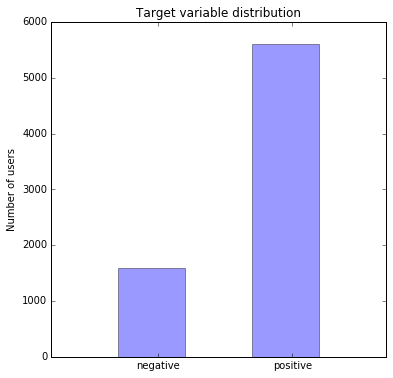

In [3]:
# Compute the distribution of the target variable
counts, bins = np.histogram(df_users_train["cls"], bins=[0,1,2])

# Plot the distribution
pl.figure(figsize=(6,6))
pl.bar(bins[:-1], counts, width=0.5, alpha=0.4)
pl.xticks(bins[:-1] + 0.3, ["negative", "positive"])
pl.xlim(bins[0] - 0.5, bins[-1])
pl.ylabel("Number of users")
pl.title("Target variable distribution")
pl.show()

## Сбор данных

Для того чтобы разработать модель, которая предсказывает значение целевой переменной для произвольного пользователя, недостаточно знать только значения идентификаторов пользоватей. Причина в том, что _user_id_ для пользователя никак не зависит от целевой переменной -- идентификатор генерируется на основании времени регистрации, сервера, обрабатывающего запрос, и номера пользователя ([подробности](https://dev.twitter.com/overview/api/twitter-ids-json-and-snowflake)).

Поэтому нам потребуется загрузить дополнительную информацию о каждом пользователе, иначе говоря провести сбор данных (data collection). Наиболее важную информацию можно загрузить из [Twitter](https://dev.twitter.com/rest/public) [API](http://www.wikiwand.com/en/Representational_state_transfer). При желании можно воспользоваться и другими источниками -- об этом ниже.

Для того, чтобы получить доступ к API прежде всего необходимо зарегистрироваться в Twitter в качестве разработчика и создать свое [приложение](https://apps.twitter.com/). После создания приложения будет доступен набор ключей, которые мы будем использовать для аутентификации. Эти ключи необходимо скопировать в соответствующие константы ниже. Подробнее о том, как работает аутентификация в Twitter API можно почитать [по ссылке](https://dev.twitter.com/oauth/application-only), хотя это нужно скорее для ознакомления: библиотека обращения с API позаботится о механизме аутентификации за нас.

In [4]:
CONSUMER_KEY = "YOUR_CONSUMER_KEY"
CONSUMER_SECRET = "YOUR_CONSUMER_SECRET_KEY"

ACCESS_TOKEN_KEY = "YOUR_ACCESS_TOKEN_KEY"
ACCESS_TOKEN_SECRET = "YOUR_ACCESS_TOKEN_SECRET"

api = twitter.Api(consumer_key=CONSUMER_KEY, 
                  consumer_secret=CONSUMER_SECRET, 
                  access_token_key=ACCESS_TOKEN_KEY, 
                  access_token_secret=ACCESS_TOKEN_SECRET)

Twitter API предоставляет информацию о местонахождении пользователя, но эта информация представлена в текстовом виде, например так:
```
"location": "San Francisco, CA"
```
Такие текстовый описания не слишком удобны для анализа, поэтому наша цель -- получить более структурированную информацию, такую как географические координаты, страна, город и т.д. Для этого удобно использовать геоинформационный сервис, например [GeoNames](http://www.geonames.org/export/web-services.html). Для его использования также необходимо зарегистрироваться, подтвердить регистрацию и включить поддержку API. После этого можно будет посылать запросы для нахождения нужной информации. Например на запрос
```
http://api.geonames.org/search?q="San Francisco, CA"&maxRows=10&username=demo
```
возвращается результат,
```javascript
{
    "totalResultsCount": 2112,
    "geonames": [
        {
            "countryId": "6252001",
            "adminCode1": "CA",
            "countryName": "United States",
            "fclName": "city, village,...",
            "countryCode": "US",
            "lng": "-122.41942",
            "fcodeName": "seat of a second-order administrative division",
            "toponymName": "San Francisco",
            "fcl": "P",
            "name": "San Francisco",
            "fcode": "PPLA2",
            "geonameId": 5391959,
            "lat": "37.77493",
            "adminName1": "California",
            "population": 805235
        },
        {
            "countryId": "6252001",
            "adminCode1": "CA",
            "countryName": "United States",
            "fclName": "spot, building, farm",
            "countryCode": "US",
            "lng": "-122.3758",
            "fcodeName": "airport",
            "toponymName": "San Francisco International Airport",
            "fcl": "S",
            "name": "San Francisco International Airport",
            "fcode": "AIRP",
            "geonameId": 5391989,
            "lat": "37.61882",
            "adminName1": "California",
            "population": 0
        }
    ]
}
```
из которого легко извлечь нужную информацию.

**Замечание: для запросов необходимо использовать своего пользователя, кроме того количество запросов ограничено 30тыс в день**.

Первым делом нам понадобится функция, которая возвращает информацию о местоположении для данного текстового запроса. Требуется реализовать функцию get_coordinates_by_location, принимающую на вход строку с местоположением и возвращает кортеж вида (широта, долгота, страна).

In [5]:
GEO_USER_NAME = "YOUR_GEO_USER_NAME"

def get_coordinates_by_location(location):
    """
    This function gets geographic coordinates and city name
    form external web service GeoNames using 'location' string.
    """
    
    data = {
        'q': location,
        'username': GEO_USER_NAME,
        'type': 'json'
    }
    
    locRequest = requests.get('http://api.geonames.org/search', params=data)
    locJSON = locRequest.json()
    
    if locJSON[u'totalResultsCount'] == 0:
        return (NaN, NaN, NaN)
    
    locJSON = locJSON[u'geonames'][0]
    
    lattitude = float(locJSON[u'lat'])
    longitude = float(locJSON[u'lng'])
    
    if u'countryName' in locJSON:
        name = locJSON[u'countryName']
    else:
        name = locJSON[u'name']
        
    return (lattitude, longitude, name)

Следующий шаг -- вызов Twitter API для сбора данных и сохранения их в data frame. После чего data frame c собранными данными совмещается с data frame, содержащим данные исходной обучающей выборки. 

В этой части задания нужно реализовать функцию `get_user_records`, которая принимает на вход прочитанный из файла `data frame` и возвращает список словарей, каждый из которых представляет данные одного пользователя. Для того, чтобы получить из объекта класса [`User`](https://github.com/bear/python-twitter/blob/master/twitter/user.py) словарь в правильном формате, нужно использовать функцию `twitter_user_to_dataframe_record` (4 балла).

Так как скрипт работает существенное время, будем сохранять промежуточный результат.

In [6]:
ts_parser = lambda date_str: dateutil.parser.parse(date_str) if pd.notnull(date_str) else None

user_records = []
tmp_file_name = 'tmp_user_records'
if os.path.exists(tmp_file_name):
    with open(tmp_file_name) as f:
        for line in f:
            try:
                user_records.append(json.loads(line))
            except:
                continue
                
processed_users = set()
for r in user_records:
    processed_users.add(r['uid'])
    
f = open(tmp_file_name, 'a')
            
def twitter_user_to_dataframe_record(user):
    dt = ts_parser(user.created_at)
    record = {
        "uid": user.id,
        "name": user.name,
        "screen_name": user.screen_name,        
        "created_at": dt.strftime("%Y-%m") if dt else dt,        
        "followers_count": user.followers_count,
        "friends_count": user.friends_count,
        "statuses_count": user.statuses_count,
        "favourites_count": user.favourites_count,
        "listed_count": user.listed_count,
        "verified": user.verified
    }
    
    if user.description is not None and user.description.strip() != "":
        record["description"] = user.description
        
    if user.location is not None and user.location.strip() != "":
        record["location"] = user.location
        record["lat"], record["lon"], record["country"] = get_coordinates_by_location(user.location)
    
    return record


def get_user_records(df):
    usersIDs = []

    # Do not process already processed users    
    for uid in df['uid'].tolist():
        if uid not in processed_users:
            usersIDs.append(uid)
    
    USERS_PER_QUERY = 100

    # Already processed records
    usersData = user_records
    
    for n in range(0, len(usersIDs), USERS_PER_QUERY):
        usersSlice = api.UsersLookup(usersIDs[n:n + USERS_PER_QUERY])
        usersSliceData = map(twitter_user_to_dataframe_record, usersSlice)
        
        for user in usersSliceData:
            json.dump(user, f)
            f.write('\n')
        
        usersData += usersSliceData
        
        print 'Processed: ' + str(n + USERS_PER_QUERY)
        
    return usersData
    
# Maximum number of user IDs returned by Twitter's user lookup

# user_records = get_user_records(df_users)

f.close()
        
print "Creating data frame from loaded data"
df_records = pd.DataFrame(user_records, columns=["uid", "name", "screen_name", "description", "verified", "location", "lat", "lon", "country", "created_at", "followers_count", "friends_count", "statuses_count", "favourites_count", "listed_count"])
print "Merging data frame with the training set"
df_full = pd.merge(df_users, df_records, on="uid", how="left")
print "Finished building data frame"

df_full

Creating data frame from loaded data
Merging data frame with the training set
Finished building data frame


,uid,cls,name,screen_name,description,verified,location,lat,lon,country,created_at,followers_count,friends_count,statuses_count,favourites_count,listed_count
0,202388889,1.0,Kim Salter,mustangkim11,Author- Artist-Marvel-Cars-Books-Music,False,"Gulfport, FL",27.74836,-82.70343,United States,2010-10,1052.0,1960.0,9477.0,21301.0,28.0
1,1392518336,0.0,Tomboy Tarts,TomboyTarts,Celebrating the classic tomboy spirit with a b...,False,Singapore/Malaysia,1.54860,103.52690,Malaysia,2013-04,1188.0,835.0,19286.0,7182.0,111.0
2,361208576,1.0,THE MANC GEEK,BigA85GL,"Mancunian geek, blogger/writer/reviewer. Consu...",False,"Manchester, UK",53.48095,-2.23743,United Kingdom,2011-08,634.0,576.0,7844.0,1141.0,28.0
3,1535215357,1.0,L,laurynjiles,I'd rather be in Paris.,False,Marvel. DC.,NaN,NaN,NaN,2013-06,2362.0,2434.0,187989.0,87935.0,68.0
4,4396196375,1.0,#1stEdifyToUplift,EdifyToUplift,Awareness.Advocacy.Ascend🎈 •Focused on buildin...,False,God is my refuge; gem❤️,NaN,NaN,NaN,2015-12,1247.0,961.0,36368.0,26724.0,75.0
5,17938477,1.0,Skelly @SPX B10,SkellyScribbles,"visual artist, writer, and photographer.",False,"Richmond, VA",37.55376,-77.46026,United States,2008-12,331.0,497.0,5448.0,8006.0,56.0
6,720288026681716737,1.0,Zane Savage,SiNGLEGADGET,"Current gadgets, tech news and reviews, in a s...",False,"Toronto, Ontario",43.70011,-79.41630,Canada,2016-04,67.0,70.0,9370.0,37.0,88.0
7,174004739,1.0,marc,_MightyMarc_,NaN,False,NaN,NaN,NaN,NaN,2010-08,369.0,1879.0,56344.0,132787.0,27.0
8,53783678,1.0,Lady Attis ⚦,ladyattis,Your friendly neighbor androgynous android. Lo...,False,"Minneapolis, MN",44.97997,-93.26384,United States,2009-07,755.0,1077.0,39137.0,69192.0,52.0
9,257662370,1.0,Nick Watches Marvel!,NickWatchesMCU,Excelsior #TrueBelievers❗️#MCU‼️ #LukeCage 9/3...,False,"Seattle, WA",47.60621,-122.33207,United States,2011-02,766.0,1374.0,19197.0,9377.0,29.0


## Exploratory Data Analysis

Для того, чтобы лучше понять, как устроена наша обучающая выборка, построим несколько графиков. Сначала построим долю "положительных" пользователей в зависимости от дня создания аккаунта. По горизонтальной оси отложим день создания аккаунта, а по вертикальной -- долю "положительных" пользователей ([подсказка](http://stroykova.github.io/sphera/l1_1.png)). Необходимо дописать код функции count_users. В функции необходимо посчитать пользователей в каждой группе (1 балл).

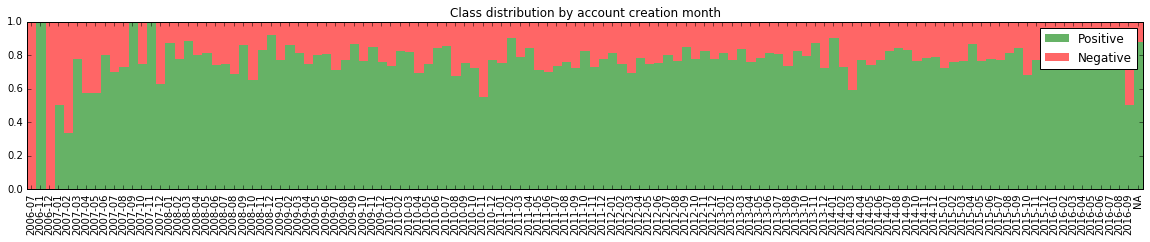

In [7]:
def count_users(grouped):
    """
    Counts number of positive and negative users
    created at each date.
    
    Returns:
        count_pos -- 1D numpy array with the counts of positive users created at each date
        count_neg -- 1D numpy array with the counts of negative users created at each date
        dts -- a list of date strings, e.g. ['2014-10', '2014-11', ...]
    """
    
    count_pos, count_neg = np.zeros(len(grouped)), np.zeros(len(grouped))
    
    dts = list(grouped.groups)
    
    for n in xrange(len(dts)):
        for cls in grouped.get_group(dts[n])['cls'].values:
            if cls == 1:
                count_pos[n] += 1
            elif cls == 0:
                count_neg[n] += 1
                
    return count_pos, count_neg, dts

grouped = df_full.groupby(map(lambda dt: dt if pd.notnull(dt) else "NA", df_full["created_at"]))

count_pos, count_neg, dts = count_users(grouped)
    
fraction_pos = count_pos / (count_pos + count_neg + 1e-10)
fraction_neg = 1 - fraction_pos

sort_ind = np.argsort(dts)
    
pl.figure(figsize=(20, 3))
pl.bar(np.arange(len(dts)), fraction_pos[sort_ind], width=1.0, color='green', alpha=0.6, linewidth=0, label="Positive")
pl.bar(np.arange(len(dts)), fraction_neg[sort_ind], bottom=fraction_pos[sort_ind], width=1.0, color='red', alpha=0.6, linewidth=0, label="Negative")
pl.xticks(np.arange(len(dts)) + 0.4, sorted(dts), rotation=90)
pl.title("Class distribution by account creation month")
pl.xlim(0, len(dts))
pl.legend()
pl.show()

Видно, что доля "положительных" аккаунтов в выборке растет с увеличением времени. Посмотрим, где живут пользователи положительной и отрицательной категории. Для этого отметим на карте каждого положительного пользователя красным, а отрицательного -- зеленым цветом ([подсказка](http://stroykova.github.io/sphera/l1_2.png)). Необходимо реализовать функцию plot_points_on_map. В функции необходимо отобразить на карте пользователей из разных классов (2 балла).

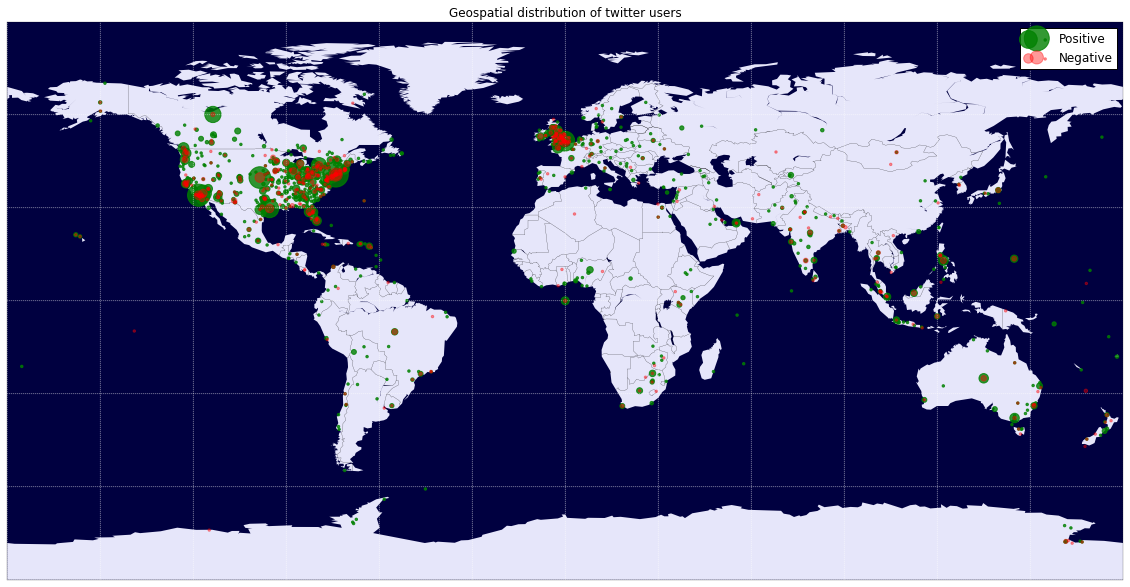

In [8]:
pl.figure(figsize=(20,12))

m = bm.Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=-180, urcrnrlon=180, resolution='c')

m.drawcountries(linewidth=0.2)
m.fillcontinents(color='lavender', lake_color='#000040')
m.drawmapboundary(linewidth=0.2, fill_color='#000040')
m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0], color='white', linewidth=0.5)
m.drawmeridians(np.arange(0,360,30),labels=[0,0,0,0], color='white', linewidth=0.5)

def plot_points_on_map(df_full):
    """
    Plot points on the map. Be creative.
    """
    
    groupedCls = df_full.groupby(['cls', 'lon', 'lat']).size()
    
    SCALE_FACTOR = 6
    
    posLatList = [i[1] for i, _ in groupedCls.iteritems() if i[0] == 1]
    posLonList = [i[2] for i, _ in groupedCls.iteritems() if i[0] == 1]
    posArea = [SCALE_FACTOR * elem for i, elem in groupedCls.iteritems() if i[0] == 1]
    
    negLatList = [i[1] for i, _ in groupedCls.iteritems() if i[0] == 0]
    negLonList = [i[2] for i, _ in groupedCls.iteritems() if i[0] == 0]
    negArea = [SCALE_FACTOR * elem for i, elem in groupedCls.iteritems() if i[0] == 0]
    
    m.scatter(posLatList, posLonList, latlon=True, s=posArea, color='green', label='Positive', alpha=0.8, zorder=2)
    m.scatter(negLatList, negLonList, latlon=True, s=negArea, color='red', label='Negative', alpha=0.4, zorder=3)
    
    return

plot_points_on_map(df_full)

pl.title("Geospatial distribution of twitter users")
pl.legend()
pl.show()

В последней картинке есть проблема: сервис геоинформации определяет координаты с точностью до города, поэтому точки, соответствующте нескольким пользователям, могут накладываться. Предложите и реализуйте способ, позволяющий справиться с этой проблемой (2 балла).


В поле ниже необходимо словами описать, как было улучшено изображение (описание необходимо для корректной проверки задания).

На изображении сделаны следующие улучшения:
* Добавлена прозрачность для меток, причем она меньше для пользователей положительного класса, т.к. их значительно больше.
* Введен параметр площади метки -- чем она больше, тем больше пользователей в конкретной области (видно, что красные метки "заметают" лишь часть площади зелёных). 

#### Опредилим пользователи какого класса популярнее, а именно пользователи какого класса имеют больше фолловеров. 

Для этого
    1. Посчитайте дескриптивные статистики для признака followers_count -- min, max, mean и median 
    2. Постройте гистограммы для пользователей двух классов.
[подсказка](http://stroykova.github.io/sphera/l1_3.png) 
    3. На основе полученных данных ответьте на вопросы 
        1. Почему mean и median имеют разные значения?
        Очень много пользователей с небольшим числом подписчиков (< 500), но встречаются и те, у кого их очень много (> 5000).
        Среднее "перетягивает" в сторону таких пользователей в отличие от медианы.
        
        2. Пользователи какого класса популярнее? Аргументируйте ответ.
        Пользователи отрицательного класса.
        Среди них чаще наблюдаются пользователи с очень большим числом подписчиков (> 10000), чем среди пользователей
        положительного класса
Подсказка: так как пользователей позитивного класса в 3.5 раза больше, чем негативного прежде чем приступать к анализу необходимо случайным образом выбрать по N(N>=500) пользователей негативного и позитивного классов. (1 балл)

Positive class:
	median:	380.0
	mean:	1704.64848485
	max:	96519.0
	min:	1.0

Negative class:
	median:	421.0
	mean:	2605.84368737
	max:	138079.0
	min:	2.0


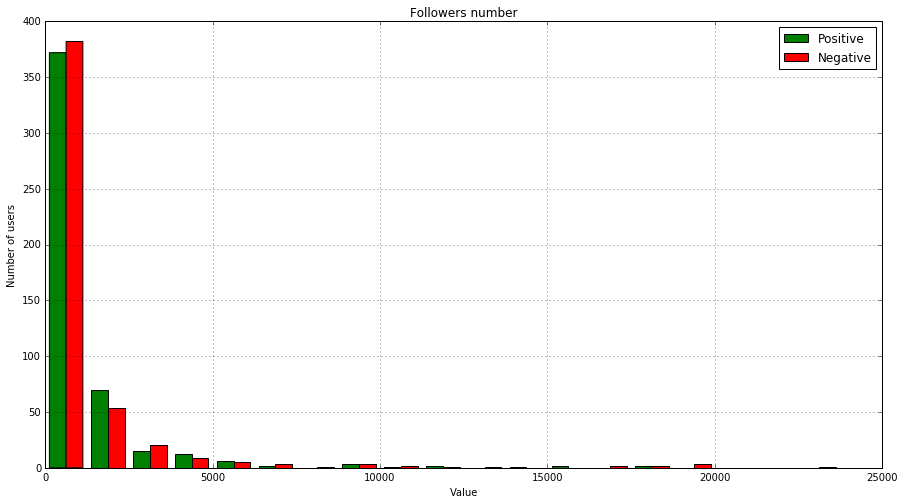

In [20]:
sample_number = 500
users_wth_neg_class = df_full[df_full["cls"]==0].sample(sample_number)
users_wth_pos_class = df_full[df_full["cls"]==1].sample(sample_number)
    
pl.figure(figsize=(15, 8))

def descriptive_stat_and_hist(users_wth_pos_class, users_wth_neg_class):
    """
    Calculate min max and median. Plot histogram
    """
    
    posFollowers = users_wth_pos_class['followers_count']
    negFollowers = users_wth_neg_class['followers_count']
    
    print 'Positive class:'
    print '\tmedian:\t', posFollowers.median()
    print '\tmean:\t', posFollowers.mean()
    print '\tmax:\t', posFollowers.max()
    print '\tmin:\t', posFollowers.min()
    
    print
    
    print 'Negative class:'
    print '\tmedian:\t', negFollowers.median()
    print '\tmean:\t', negFollowers.mean()
    print '\tmax:\t', negFollowers.max()
    print '\tmin:\t', negFollowers.min()
    
    posHist = [user for user in posFollowers if pd.notnull(user)]
    negHist = [user for user in negFollowers if pd.notnull(user)]
    
    pl.hist([posHist, negHist], bins=20, range=(0, 25000), label=['Positive', 'Negative'], color=['green', 'red'])
    
    return

descriptive_stat_and_hist(users_wth_pos_class, users_wth_neg_class)

pl.title('Followers number')
pl.grid()
pl.xlabel('Value')
pl.ylabel('Number of users')
pl.legend()
pl.show()


Смотрим на полученный data frame и сохраняем его в .csv файл.

In [16]:
OUT_FILE_PATH = "hw1_out.csv"
print "Saving output data frame to %s" % OUT_FILE_PATH
df_full.to_csv(OUT_FILE_PATH, sep="\t", index=False, encoding="utf-8", quoting=csv.QUOTE_NONNUMERIC)
df_full.head()

Saving output data frame to hw1_out.csv


,uid,cls,name,screen_name,description,verified,location,lat,lon,country,created_at,followers_count,friends_count,statuses_count,favourites_count,listed_count
0,202388889,1.0,Kim Salter,mustangkim11,Author- Artist-Marvel-Cars-Books-Music,False,"Gulfport, FL",27.74836,-82.70343,United States,2010-10,1052.0,1960.0,9477.0,21301.0,28.0
1,1392518336,0.0,Tomboy Tarts,TomboyTarts,Celebrating the classic tomboy spirit with a b...,False,Singapore/Malaysia,1.54860,103.52690,Malaysia,2013-04,1188.0,835.0,19286.0,7182.0,111.0
2,361208576,1.0,THE MANC GEEK,BigA85GL,"Mancunian geek, blogger/writer/reviewer. Consu...",False,"Manchester, UK",53.48095,-2.23743,United Kingdom,2011-08,634.0,576.0,7844.0,1141.0,28.0
3,1535215357,1.0,L,laurynjiles,I'd rather be in Paris.,False,Marvel. DC.,NaN,NaN,NaN,2013-06,2362.0,2434.0,187989.0,87935.0,68.0
4,4396196375,1.0,#1stEdifyToUplift,EdifyToUplift,Awareness.Advocacy.Ascend🎈 •Focused on buildin...,False,God is my refuge; gem❤️,NaN,NaN,NaN,2015-12,1247.0,961.0,36368.0,26724.0,75.0
